In [10]:
%pylab inline

import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches


from collections import defaultdict, Counter, OrderedDict

import cytograph as cg
import loompy
import palettable

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
from scbeta_scrnaseq import utils
from scbeta_scrnaseq import vis
import scbeta_scrnaseq.cytograph_inmem_utils as cgm
import scbeta_scrnaseq.cytograph_analyses as cga

from scbeta_scrnaseq.figure_vis import core_colors
import scbeta_scrnaseq.figure_vis as fv
fv.setup_matplotlib_params()

Populating the interactive namespace from numpy and matplotlib


/Users/averes/miniconda3/envs/py36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['fv']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
import glob
pb_tpm = {}
for pbf in glob.glob('../*/data/complete_processing/*.pseudobulk_tpm.df.npz'):
    key = os.path.basename(pbf)[:-(len('.pseudobulk_tpm.df.npz'))]
    pb_tpm[key] = utils.load_df(pbf)
    
pb_expr = {}
for pbf in glob.glob('../*/data/complete_processing/*.expr_frac.df.npz'):
    key = os.path.basename(pbf)[:-(len('.expr_frac.df.npz'))]
    pb_expr[key] = utils.load_df(pbf)

In [12]:


cluster_order = [
    ('stage6.labels', 'scbeta', ),
    ('stage6.labels', 'ph', ),
    ('human_islets.labels', 'beta'),
    ('human_islets.labels', 'alpha'),
]

cluster_tpm = utils.combine_rows(pb_tpm, cluster_order)
cluster_expr = utils.combine_rows(pb_expr, cluster_order)

## Figure 2F

In [13]:
log2_tpm = np.log2(cluster_tpm + 1)

In [14]:
fc_thr = 4
min_expr = 50

alpha_beta_log_fc = log2_tpm.loc['human_islets.labels alpha'] - log2_tpm.loc['human_islets.labels beta']
alpha_beta_de_genes = (alpha_beta_log_fc.abs() > np.log2(fc_thr)) & ((cluster_tpm.loc['human_islets.labels alpha'] > min_expr ) | (cluster_tpm.loc['human_islets.labels beta'] > min_expr))

up_alpha = (alpha_beta_de_genes) & (alpha_beta_log_fc > 0)
up_beta = (alpha_beta_de_genes) & (alpha_beta_log_fc < 0)

In [15]:
print(sum(up_alpha), sum(up_beta))

99 79


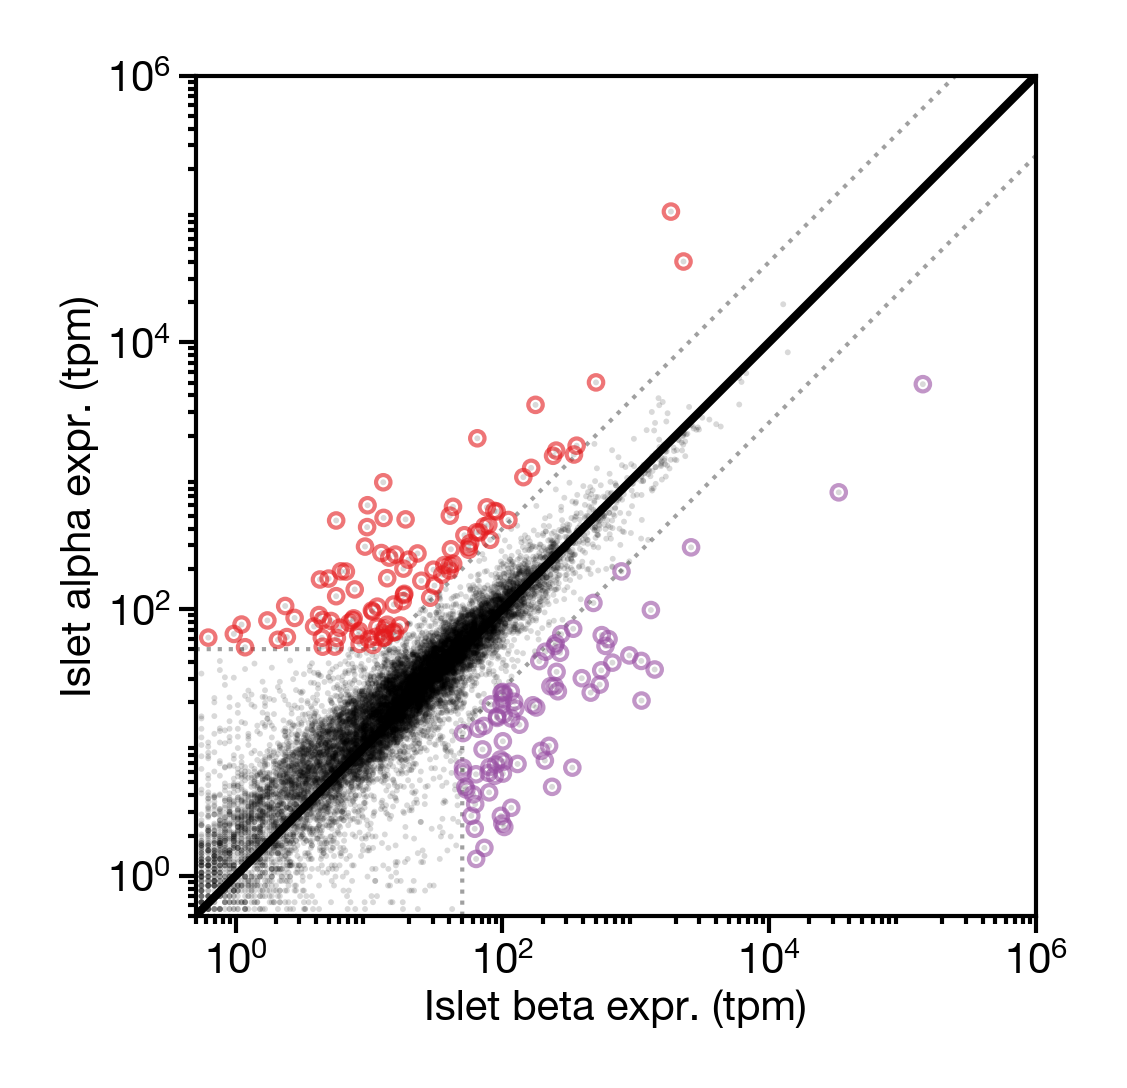

In [16]:
fig = plt.figure(figsize=(2, 2), dpi=600)
fig.patch.set_alpha(0.0)
gs = gridspec.GridSpec(1,1, fig, 0.25, 0.25, 0.95, 0.95, hspace=0, wspace=0)

ax = fig.add_subplot(gs[0],
                  xscale='log', yscale='log',
                frameon=True)

ax.set_xlabel('Islet beta expr. (tpm)', labelpad=1)
ax.set_ylabel('Islet alpha expr. (tpm)', labelpad=1)
# de_genes = (log_fc.abs() > permuted_max_fc) & (log_fc.abs() > np.log2(fc_thr))

x = cluster_tpm.loc['human_islets.labels beta']
y = cluster_tpm.loc['human_islets.labels alpha']

ax.scatter(x, y, c='k', s=0.5, edgecolor='none', 
           alpha=0.15, rasterized=True)

ax.scatter(x[up_alpha], y[up_alpha], s=3, facecolor='none', edgecolor=core_colors.red,
           alpha=0.6, linewidths = 0.5, cmap='RdBu')

ax.scatter(x[up_beta], y[up_beta], s=3, facecolor='none', edgecolor=core_colors.purple,
           alpha=0.6, linewidths = 0.5, cmap='RdBu')


plot_lims = np.array([0.5, 10**6])
ax.plot(plot_lims, plot_lims, linestyle='-',linewidth=1.0, color='k', zorder=-10)


# for fc in [fc_thr, 1./fc_thr]:
ax.plot((plot_lims[0], min_expr/fc_thr, plot_lims[1]), 
            (min_expr, min_expr, fc_thr*plot_lims[1]),
            linestyle='dotted', linewidth=0.5, color='#a0a0a0', zorder=-10)

ax.plot((min_expr, min_expr, plot_lims[1]),
        (plot_lims[0], min_expr/fc_thr, plot_lims[1]/fc_thr), 
            linestyle='dotted', linewidth=0.5, color='#a0a0a0', zorder=-10)

ax.set_xlim(plot_lims)
ax.set_ylim(plot_lims)

ax.set_xticks(10**np.arange(0, 7, 2))
ax.set_yticks(10**np.arange(0, 7, 2))

# ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
    
fig.savefig('../../figures/components/extended_figure4/ExtendedFigure4B.pdf', dpi=600, transparent=True)


In [17]:

sc_mean = 2**((log2_tpm.loc['stage6.labels scbeta'] + log2_tpm.loc['stage6.labels ph'])/2)
sc_log_fc = log2_tpm.loc['stage6.labels scbeta'] - log2_tpm.loc['stage6.labels ph']
expr_in_sc = sc_mean > 10


alpha_and_sc = up_alpha[up_alpha].index.intersection(expr_in_sc[expr_in_sc].index)
beta_and_sc = up_beta[up_beta].index.intersection(expr_in_sc[expr_in_sc].index)

low_in_sc = expr_in_sc[~expr_in_sc].index.intersection(up_alpha[up_alpha | up_beta].index)

In [18]:
from matplotlib import  lines

In [19]:
sp.stats.ttest_ind(sc_log_fc[beta_and_sc].values, sc_log_fc[alpha_and_sc].values), sp.stats.mannwhitneyu(sc_log_fc[beta_and_sc].values, sc_log_fc[alpha_and_sc].values)

(Ttest_indResult(statistic=9.322907839451702, pvalue=3.6352209514682975e-16),
 MannwhitneyuResult(statistic=452.0, pvalue=1.6993101793069913e-14))

In [20]:
sp.stats.ttest_ind(sc_log_fc[beta_and_sc].values, sc_log_fc[alpha_and_sc].values), sp.stats.mannwhitneyu(sc_log_fc[beta_and_sc].values, sc_log_fc[alpha_and_sc].values)

(Ttest_indResult(statistic=9.322907839451702, pvalue=3.6352209514682975e-16),
 MannwhitneyuResult(statistic=452.0, pvalue=1.6993101793069913e-14))

In [21]:
mwu_test = sp.stats.mannwhitneyu(sc_log_fc[beta_and_sc].values, sc_log_fc[alpha_and_sc].values, alternative='greater')

In [22]:
mwu_test.pvalue

1.6993101793069913e-14

2019-02-20 16:29:03,225 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
2019-02-20 16:29:03,233 WARNING: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


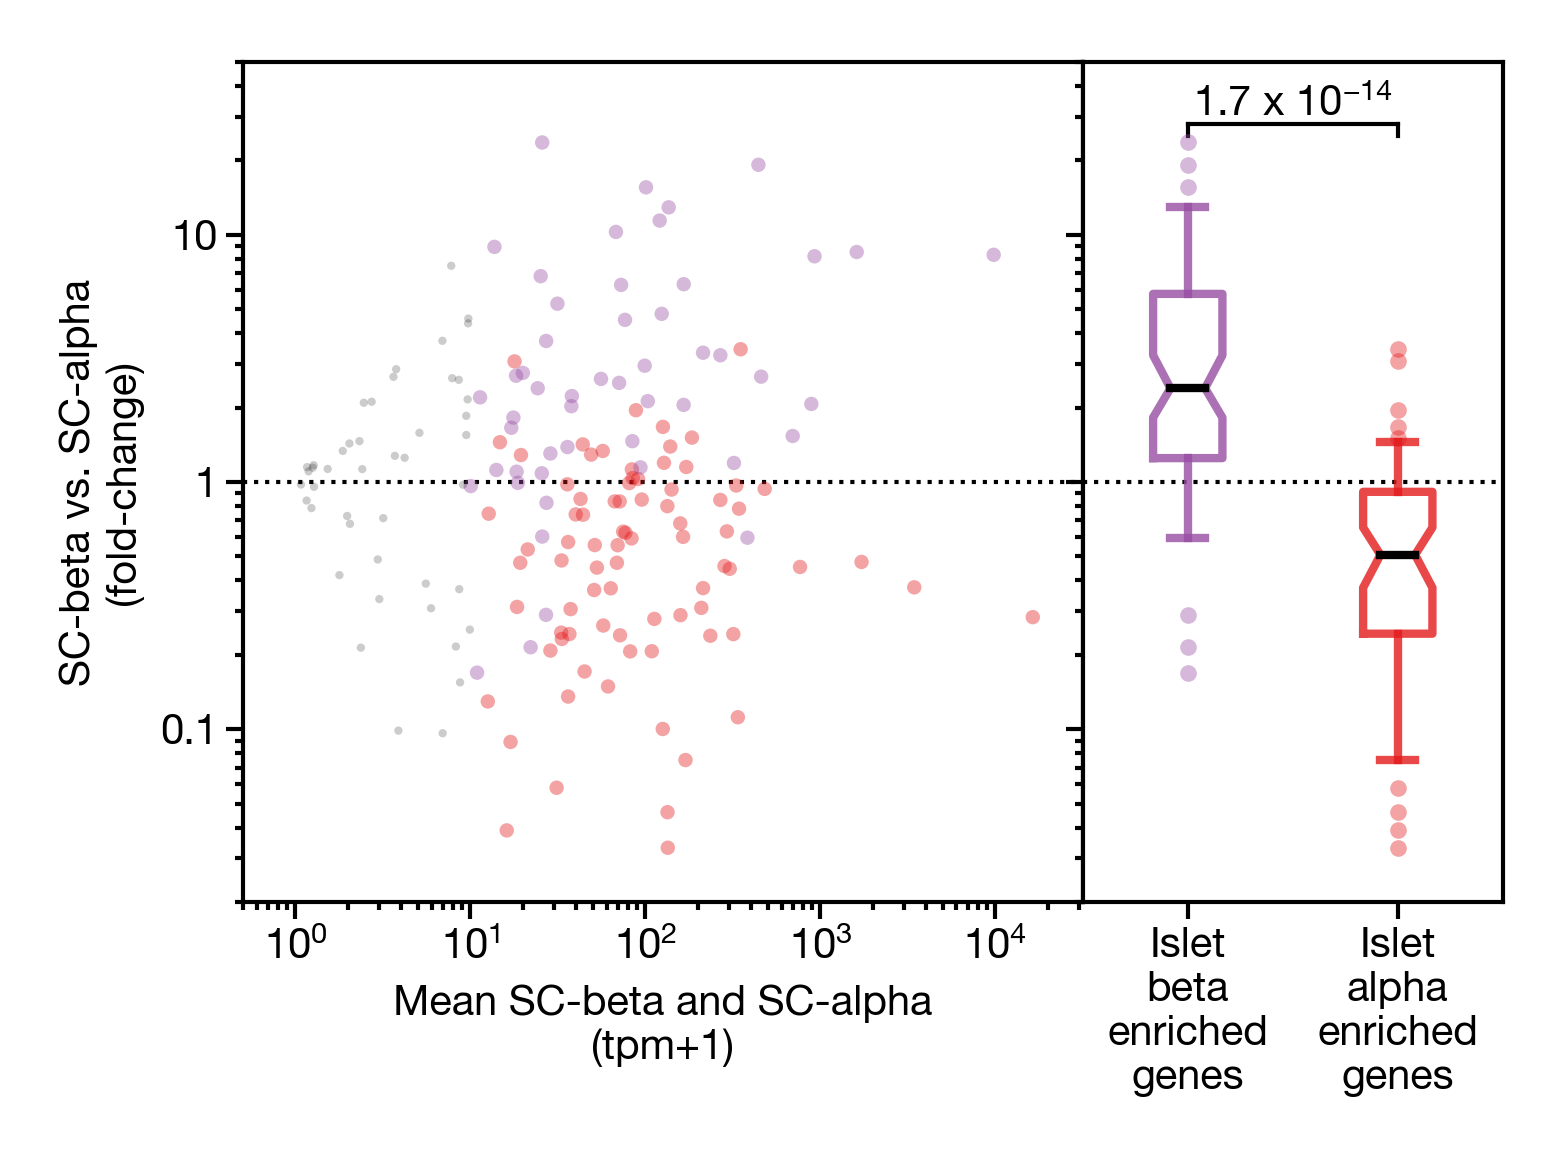

In [23]:
fig = plt.figure(figsize=(3, 2), dpi=600)

gs = gridspec.GridSpec(1, 2, fig, 0.25, 0.25, 0.95, 0.95, hspace=0, wspace=0, width_ratios=[1.5, 0.75])


ax = fig.add_subplot(gs[0],
                  xscale='log', yscale='log', frameon=True)

ax.set_xlabel('Mean SC-beta and SC-alpha\n(tpm+1)', fontsize=5, labelpad=2)
ax.set_ylabel('SC-beta vs. SC-alpha\n(fold-change)', fontsize=5, labelpad=2)

x = sc_mean
y = 2**sc_log_fc
ax.scatter(x[alpha_and_sc], y[alpha_and_sc],
           s=3,
           c=core_colors.red, edgecolor='none',
           linewidths = 0.5, alpha=0.4)

ax.scatter(x[beta_and_sc], y[beta_and_sc],
           s=3,
           c=core_colors.purple, edgecolor='none',
           linewidths = 0.5, alpha=0.4)

ax.scatter(x[low_in_sc], y[low_in_sc],
           s=1, edgecolor='none', facecolor='k',
           linewidths = 0.5, alpha=0.2)

plot_lims = np.array([0.5, 10**4.5])
ax.plot(plot_lims, [1,1], linestyle='dotted',linewidth=0.5, color='k', zorder=-100)

ax.set_xlim(plot_lims)

ylim = np.abs(np.log10(ax.get_ylim())).max()
ylim = np.log10(50)
ax.set_ylim([10**(-ylim), 10**ylim])
ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels([0.1, 1, 10])


ax = fig.add_subplot(gs[1], yscale='log')

bwidth=0.33

for pos, col, filt in [(1, core_colors.purple, beta_and_sc), (2, core_colors.red, alpha_and_sc)]:
    bprops = dict(clip_on=False, color=tuple(col), alpha=0.80)
    mprops = {**bprops, 'alpha':1, 'color':'k'}
    fprops = dict(marker='o', markersize=2, markeredgecolor='none', markerfacecolor=tuple(col), alpha=0.40)
    bp = ax.boxplot([2**sc_log_fc[filt].values],
                   notch=True, bootstrap=1000, zorder=10, whis=[5,95], widths=bwidth, positions=[pos],
                   boxprops=bprops, whiskerprops=bprops, capprops=bprops, medianprops=mprops, flierprops=fprops)
               

ax.set_xlim([0.5, 2.5])
ax.set_xticks([1, 2])
ax.set_xticklabels(['Islet\nbeta\nenriched\ngenes', 'Islet\nalpha\nenriched\ngenes'], fontsize=5)


ax.plot(ax.get_xlim(), [1,1], linestyle='dotted',linewidth=0.5, color='k', zorder=-100)

ax.set_ylim([10**(-ylim), 10**ylim])
ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels([''])



# line_offset = ax.get_ylim()[1] + 0.5
line_pos = 28

line = lines.Line2D([1, 2], [line_pos, line_pos], color='k', linewidth=0.5)
ax.add_line(line)
line = lines.Line2D([1, 1], [line_pos-3, line_pos], color='k', linewidth=0.5)
ax.add_line(line)
line = lines.Line2D([2, 2], [line_pos-3, line_pos], color='k', linewidth=0.5)
ax.add_line(line)
# line.set_clip_on(False)

ax.text(1.5,28, r'1.7 x $10^{-14}$', va='bottom', ha='center', fontsize=5)



fig.savefig('../../figures/components/extended_figure4/ExtendedFigure4D.pdf', dpi=600, transparent=True)

0 LOXL4 0 [132] 133
1 GCG 5 [130] 133
2 DPP4 10 [129] 133
3 IRX2 15 [127] 133
4 ARX 20 [126] 133
5 TTR 25 [115] 133
6 STC2 30 [114] 133
7 CRYBA2 35 [107] 133
(-0.5, 132.5)


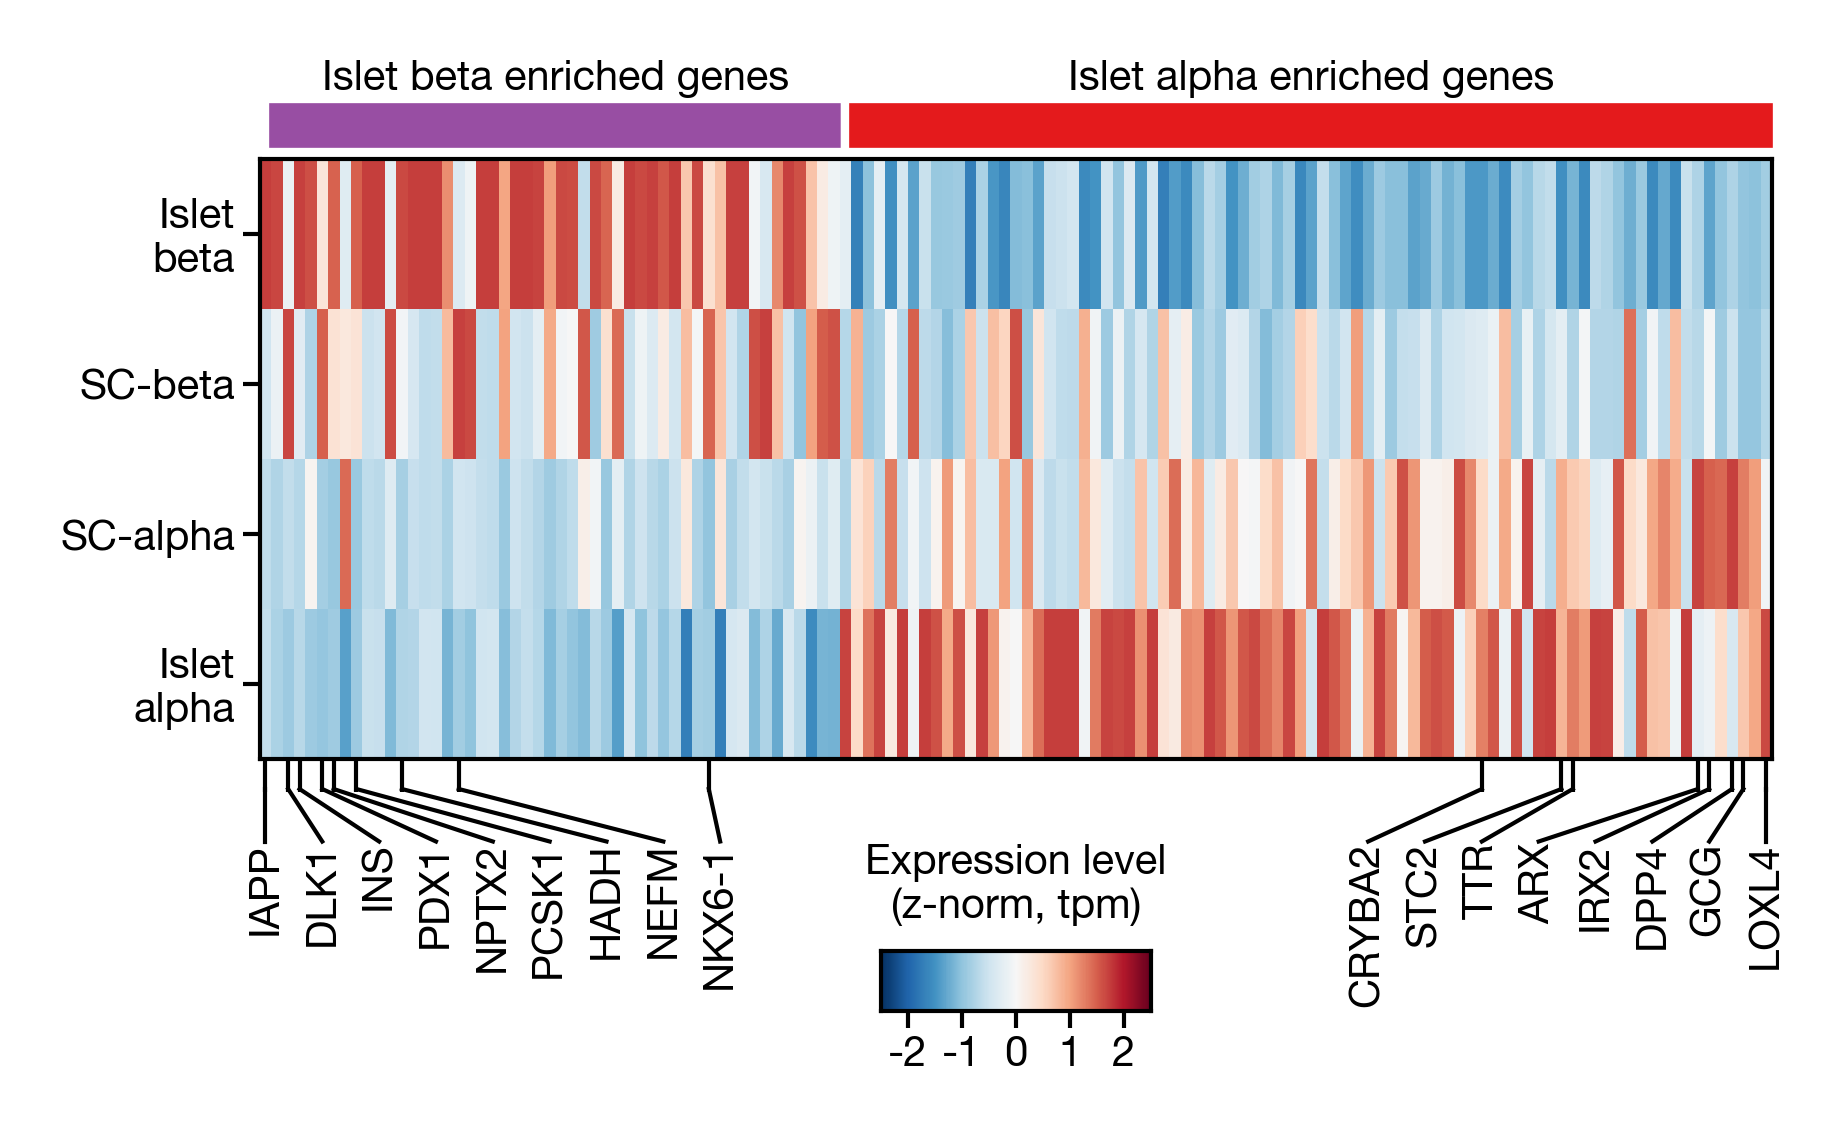

In [24]:
fig = plt.figure(figsize=(3,2), dpi=600)
fig.patch.set_alpha(0.0)

gs = gridspec.GridSpec(1, 1, fig, 0.15, 0.30, 0.99, 0.80, hspace=0.2, wspace=0)

ax = fig.add_subplot(gs[0],
              xscale='linear', yscale='linear',
            xlabel='', ylabel='', frameon=True)

heatmap_genes = alpha_beta_log_fc[(up_alpha | up_beta) & expr_in_sc].sort_values(ascending=True).index
relative_expression = cluster_tpm[heatmap_genes].T
cmap = palettable.colorbrewer.diverging.RdBu_11_r.get_mpl_colormap()

sample_order = ['human_islets.labels beta',
                'stage6.labels scbeta',
                'stage6.labels ph',
                'human_islets.labels alpha']
sample_labels = ['Islet\nbeta', 'SC-beta', 'SC-alpha', 'Islet\nalpha']

relative_expression = relative_expression[sample_order].T
# logtmp, and Zscale
# relative_expression = np.log10(relative_expression)
relative_expression -= relative_expression.mean()
relative_expression /= relative_expression.std(ddof=0)
imax = ax.imshow(relative_expression,
      cmap=cmap, aspect='auto', 
          vmin=-2.5, vmax=2.5,
         )

### Add boxes

n_beta = sum(alpha_beta_log_fc[heatmap_genes] < 0)
n_alpha = sum(alpha_beta_log_fc[heatmap_genes] > 0)

rec_y = 0.90
rec_w = 0.35
ax.add_patch(
    patches.Rectangle((0, -rec_y), (n_beta), rec_w,
                      facecolor=core_colors.purple, alpha=1, clip_on=False,
                      edgecolor='w',
                     ))

ax.text(n_beta/2, -rec_y-0.01, 'Islet beta enriched genes', 
            fontsize=rcParams['xtick.labelsize'],
            horizontalalignment='center', verticalalignment='bottom', clip_on=False)

ax.add_patch(
    patches.Rectangle((n_beta, -rec_y), (n_alpha), rec_w,
                      facecolor=core_colors.red, alpha=1, clip_on=False,
                      edgecolor='w',
                     ))

ax.text(n_beta + n_alpha/2, -rec_y-0.01, 'Islet alpha enriched genes', 
            fontsize=rcParams['xtick.labelsize'],
            horizontalalignment='center', verticalalignment='bottom', clip_on=False)


### Add labels
ax.set_yticks(range(len(sample_labels)))
ax.set_yticklabels(sample_labels)

beta_labels_genes = ['INS', 'IAPP', 'NPTX2', 'HADH', 'NEFM', 'DLK1', 'NKX6-1', 'PCSK1', 'PDX1']
alpha_labels_genes = [ 'GCG', 'ARX', 'IRX2', 'DPP4', 'TTR', 'STC2', 'LOXL4', 'CRYBA2']
xticks = []

label_spacing = 5
current_label_pos = 0

label_shifts = {}
for gp,g in enumerate(alpha_beta_log_fc[beta_labels_genes].sort_values().index):
    gi = np.where(heatmap_genes == g)[0]
    xticks.append(gi[0])
    label_shifts[g] = gi[0] - gp*label_spacing
    

for gp,g in enumerate(alpha_beta_log_fc[alpha_labels_genes].sort_values(ascending=False).index):
    gi = np.where(heatmap_genes == g)[0]
    xticks.append(gi[0])
    print(gp, g, gp*label_spacing, gi, len(heatmap_genes))
    label_shifts[g] = gi[0] - ((len(heatmap_genes) - 1) - gp*label_spacing)
    

    
labels_genes = []
for gi in xticks:
    labels_genes.append(heatmap_genes[gi])
ax.set_xticks(xticks)
ax.set_xticklabels(labels_genes, rotation=90)

import types
for label in ax.xaxis.get_majorticklabels():
    if label._text in label_shifts:
        label.customShiftValue = label_shifts[label._text]
        label.set_x = types.MethodType( lambda self, x: matplotlib.text.Text.set_x(self, x-self.customShiftValue ), 
                                        label)
print(ax.get_xlim())
for x0, lab in zip(xticks, labels_genes):
    if lab in label_shifts:
        x1 = x0 - label_shifts[lab]
    else:
        x1 = x0    
    ax.plot([x0, x1], [3.7, 4.05], 'k-', clip_on=False, lw=0.50)
        
    
ax.set_ylim([3.5, -0.5])
ax.set_xlim([-0.5, -0.5+len(heatmap_genes)])
ax.tick_params(pad=6, axis='x', length=4)
### Add Colorbar

cax_position = [0.495, 0.09, 0.15, 0.05]

cax1 = fig.add_axes(cax_position,
                xscale='linear', yscale='linear',
                xlabel='', ylabel='', frameon=True)

cmap_range = (-2.5, 2.5)
cax1.imshow(np.linspace(cmap_range[0], cmap_range[1], 1000).reshape(1,-1),
      cmap=cmap, aspect='auto', extent=(-2.5, 2.5, 0, 1),
          vmin=-2.5, vmax=2.5,
         )
cax1.set_xticks((-2,-1,0,1,2))
cax1.set_xticklabels(range(-2,3), fontsize=5)
cax1.set_yticks([])

cax1.set_xlabel('Expression level\n(z-norm, tpm)', fontsize=5)
cax1.xaxis.set_label_position('top') 
cax1.tick_params(pad=1)

# cax1.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
    
fig.savefig('../../figures/components/extended_figure4/ExtendedFigure4C.pdf', dpi=600, transparent=True)

In [25]:
from sklearn.neighbors.kde import KernelDensity

In [28]:
ds = loompy.connect('../02_Stage_6/data/complete_processing/stage6.processed2.loom')
utils.preload_ds_vals(ds)

In [29]:
tpm_normalizer = cgm.CountsNormalizer(normalize_variance=False, mean_center=False, level=10**6)
tpm_normalizer.fit(ds.vals)

In [30]:
# plt.hist(wk_cl_log_tpms.ravel())

In [31]:
grp_week_gene_kdes = {}
grp_week_gene_log_dens = {}
grp_week_gene_medians = {}

kde_domain = np.linspace(2, 7, 100).reshape(-1,1)
for g in ('INS', 'GCG'):
    
    gi = np.where(ds.ra.Gene == g)[0]
    for wk in range(6):
        for cl in ('scbeta', 'ph'):
            
            cell_filter = (ds.ca.CellWeek == wk) & (ds.ca.Labels ==cl)
            cells = np.where(cell_filter)[0]
            
            wk_cl_log_tpms = np.log10(tpm_normalizer.transform(ds.vals, genes=gi, cells=cells) + 1000)
            kde = KernelDensity(kernel='exponential', bandwidth=0.08).fit(wk_cl_log_tpms.reshape(-1,1))
            
            grp_week_gene_kdes[(cl, wk, g)] = kde
            grp_week_gene_log_dens[(cl, wk, g)] = kde.score_samples(kde_domain)
            grp_week_gene_medians[(cl, wk, g)] = np.median(wk_cl_log_tpms)

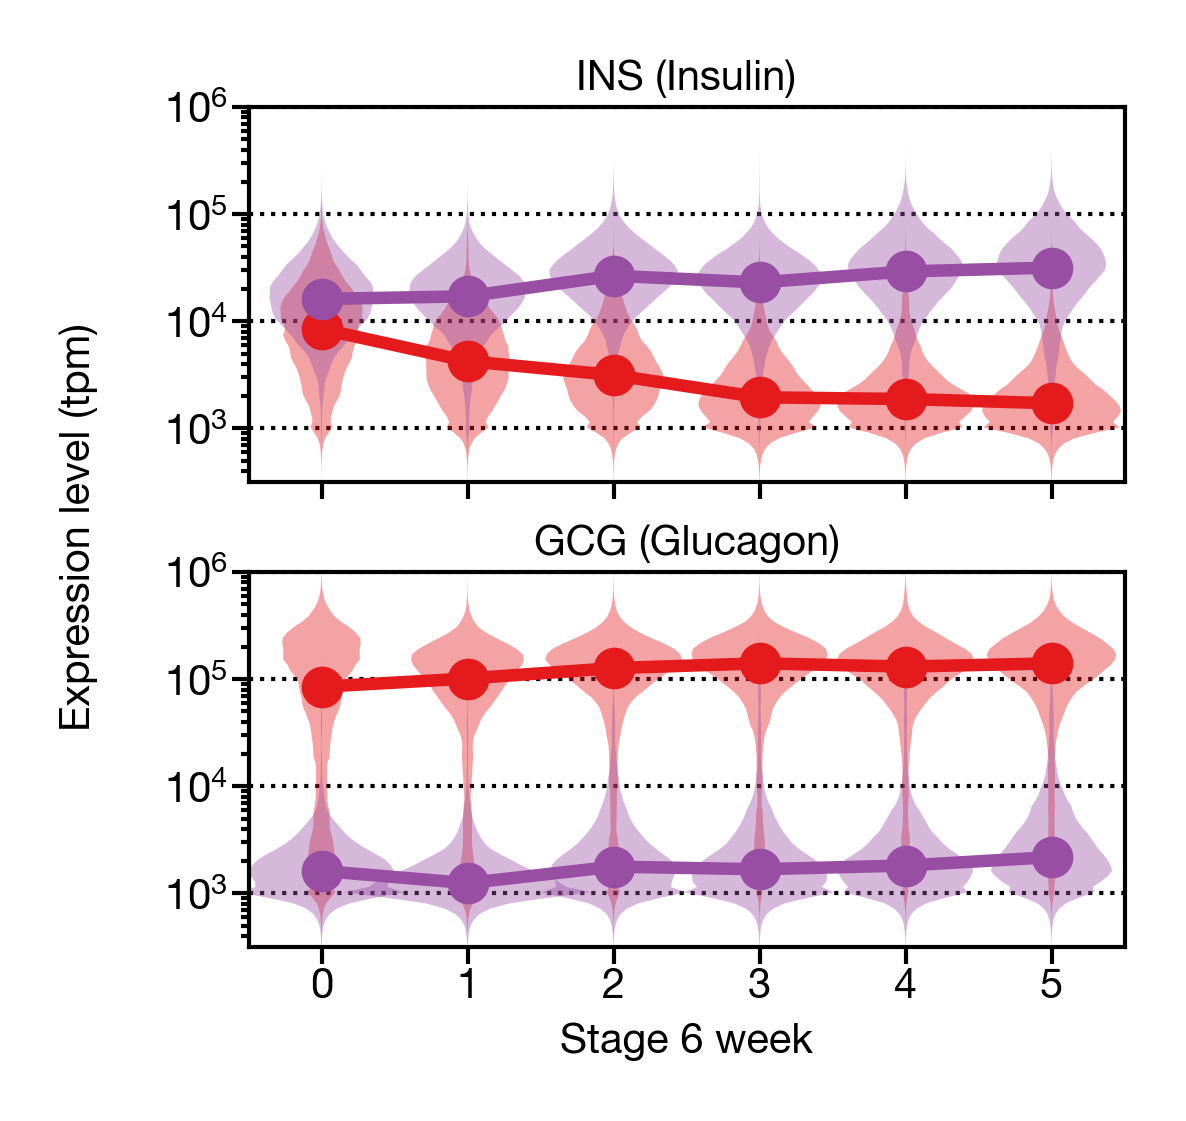

In [32]:
rcParams['axes.titlepad'] = 1

fig = plt.figure(figsize=(2,2), dpi=600)
fig.patch.set_alpha(0.0)

gs = gridspec.GridSpec(2, 1, fig, 0.22, 0.25, 0.95, 0.95, hspace=0.24, wspace=0)

ax = fig.add_subplot(gs[:],
              xscale='linear', yscale='linear',
            xlabel='', ylabel='', frameon=False)
ax.set_xticks([])
ax.set_yticks([])
# ax.yaxis.set_label_position('right')
ax.set_ylabel('Expression level (tpm)', labelpad=18)

violin_w = 0.3
for gi, (g, gmax, gname) in enumerate([('INS', 10**5.5, 'INS (Insulin)'), ('GCG', 10**6, 'GCG (Glucagon)')]):
#     ax = fig.add_subplot(gs[gi],
#               xscale='linear', yscale='linear',
#             xlabel='', ylabel=g, frameon=False)
#     ax.set_xticks([])
#     ax.set_yticks([])
    
    
    ax = fig.add_subplot(gs[gi],
              xscale='linear', yscale='log',
            xlabel='', ylabel='', frameon=True)
    
    ax.set_title(gname, pad=2)

    for cli,(cl,col) in enumerate([('ph', core_colors.red), ('scbeta', core_colors.purple)]):
        for wk in range(6):
            y = 10**kde_domain.ravel()

            x1 = wk + violin_w*np.exp(grp_week_gene_log_dens[(cl, wk, g)])
            x2 = wk - violin_w*np.exp(grp_week_gene_log_dens[(cl, wk, g)])

            fb = ax.fill_betweenx(y, x1, x2, edgecolor='none', facecolor=col, alpha=0.4)
    #         fb = ax.fill_betweenx(y, x1, x2, edgecolor='k', facecolor='none', alpha=1.0, linewidth=0.5)

        med_line = 10**np.array([grp_week_gene_medians[(cl, wk, g)] for wk in range(6)])
        ax.plot(range(6), med_line, marker='o', markersize=4,
               color=col)
        
#     ax.text(ax.get_xlim()[0], gmax, g, ha='left', va='top')
    
    ax.set_xlim((-0.5, 5.5))
    
    
    ax.set_yticks([10**3, 10**4, 10**5, 10**6])
    ax.set_ylim((10**2.5, 10**6))
#     ax.yaxis.tick_right()

    ax.grid(True)
    ax.yaxis.grid(color='k', linestyle='dotted', linewidth=0.5)
    ax.xaxis.grid(color='none', linestyle='dotted')
    ax.set_axisbelow(True)
    
    
    ax.set_xticks(range(6))
    ax.set_xticklabels([])
    if ax.is_last_row():
        ax.set_xticklabels(range(6))
        ax.set_xlabel('Stage 6 week', labelpad=2, fontsize=5)
    
    ax.tick_params(axis='both', which='major', pad=0.5, width=0.5, zorder=-10, length=2)
    
fig.savefig('../../figures/components/extended_figure4/ExtendedFigure4A.pdf', dpi=600, transparent=True)
    
